# Beamforming (pytorch)

In this notebook, we locate the source of a synthetic wavefield recorded on an array of sensors using beamforming. The notebook follows three steps:

1. Geometry: define the geometry of sensors, source, and gridpoints to test
2. Recordings (synthetic): compute synthetic seismograms recorded on each sensor
3. Beamforming: compute cross-correlation beamformer output within a frequency band

For more background information, see the README.

**Memory limitation**

The memory-limit you will likely encounter first is the size of $S$, which has the shape `(n_gridpoints, n_sensors, n_sensors, n_frequencies)`. For example, $S$ would have to be **6.5 TiB**, far exceeding most systems, with these parameters:
* `n_sensors = 1000`
* `grid_limit = 100`
* `grid_spacing = 2`
* `window_length = 100`
* `sampling_rate = 10`
* `fmin, fmax = 0.1, 1.0`

See `beamforming_dask.ipynb` for the adapted `dask`-version of this notebook, which is able to compute the beampowers for the parameters above.

**On `pytorch` vs `numpy`**

Note that the `pytorch` functions in this notebook can be replaced mostly one-to-one with `numpy` equivalents. However, from my experience on my machine, `numpy` is significantly slower (about 50%), particularly when using `einsum()`.

## 1. Geometry

Text(0.5, 1.0, 'geometry of sensors, source, and grid')

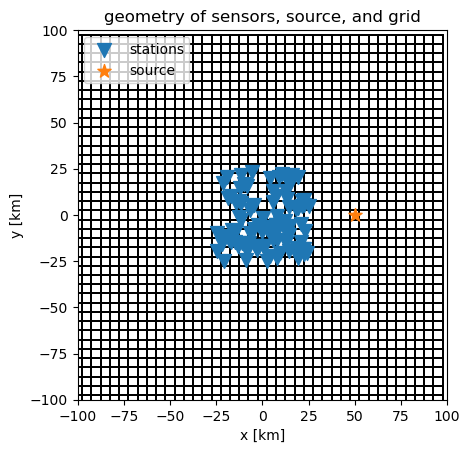

In [5]:
from itertools import product

import pylab as plt
import torch

torch.manual_seed(42)

# geometry of the problem
n_sensors = 100
# uniform random distribution in [-25, 25]
stations = torch.rand((n_sensors, 2)) * 50
stations -= 25
source = torch.tensor([50, 0])

# generate grid points
grid_limit = 100
grid_spacing = 5
grid_coords = torch.arange(-grid_limit, grid_limit, grid_spacing)
gridpoints = torch.tensor(list(product(grid_coords, repeat=2)))

# generate empty grid cells for visulation
xx, yy = torch.meshgrid(grid_coords, grid_coords, indexing="xy")
empty_cells = torch.zeros_like(xx) * torch.nan

# plotting
fig, ax = plt.subplots(1)
ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.01)
ax.scatter(*stations.T, marker="v", s=100, label="stations")
ax.scatter(*source, marker="*", s=100, label="source")
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect("equal")
ax.legend(loc=2)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_title("geometry of sensors, source, and grid")

## 2. Recordings (synthetic)

In a field data application, replace `waveform_spectra` by the spectra of your recordings.

Text(0.5, 1.0, '(synthetic) recordings on sensors')

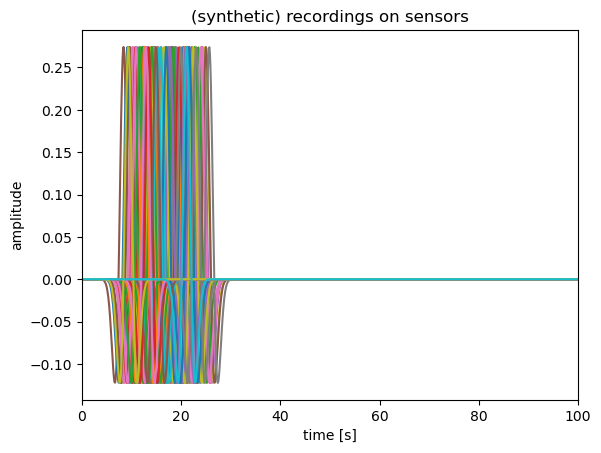

In [6]:
from scipy.signal import ricker

# define time
window_length = 100
sampling_rate = 10
times = torch.arange(0, window_length + 1 / sampling_rate, 1 / sampling_rate)

# compute frequencies
freqs = torch.fft.fftfreq(len(times), 1 / sampling_rate)
omega = 2 * torch.pi * freqs

# define medium
# acoustic homogeneous half-space
medium_velocity = 3

# compute travel times
distances = torch.linalg.norm(stations - source, axis=1)
traveltimes = distances / medium_velocity

# define source wavelet
wavelet = torch.fft.fft(torch.from_numpy(ricker(len(times), sampling_rate)))

# compute waveforms for all stations for given source
# Green's functions are exp(-iωt)
# waveforms are only computed for plotting purposes.
# In a usual field data application, waveforms already exist
# and waveform_spectra need to be computed.
waveform_spectra = wavelet * torch.exp(-1j * omega[None, :] * traveltimes[:, None])
waveforms = torch.fft.fftshift(torch.fft.ifft(waveform_spectra, axis=1).real)

# plotting
fig, ax = plt.subplots(1)
ax.plot(times, waveforms.T)
ax.set_xlim(0, window_length)
ax.set_xlabel("time [s]")
ax.set_ylabel("amplitude")
ax.set_title ("(synthetic) recordings on sensors")


## 3. Beamforming

Here, we compute beampowers using cross-correlation beamforming

$B(\mathbf{r_s}) = \sum_\omega \sum_j \sum_{k\neq j} K_{jk}(\omega) S_{kj}(\mathbf{r_s}, \omega)$,

with $B$ the beampower for potential source location $\mathbf{r_s}$, $j,k$ the sensors indices, $K$ the cross-spectral density matrix of recorded signals, and $S$ the cross-spectral density matrix of Green's functions (or replica vectors). For more details, see the README.

**Note on plane-wave beamforming**

The kind of beamforming here is Matched Field Processing, i.e., testing a spatial grid and not a slowness grid. For plane-wave beamforming, make three changes to this notebook:
1. Change the grid from spatial ($x, y$) to horizontal slownesses ($u_x, u_y$)
2. Adapt the computation of travel times to $t = u_x x_j + u_y y_j$, where $x_j, y_j$ is the position of sensor $j$ relative to a reference point.
3. Plot slowness grid instead of spatial view for beamforming result

In [7]:
# Frequency band to use for beamform
fmin, fmax = 0.1, 1.0

# theoretical traveltimes between all stations and all grid points
# Note that in this demonstration we know the velocity of the medium.
# In a field data application, medium_velocity may be another dimension to test.
# In that case, you can keep changes to the remaining logic minimal by
# keeping traveltimes as 1D tensor, i.e., with contents (gp1_v1, gp1_v2, ... gpN_vN-1, gpN_vN).
distances_to_all_gridpoints = torch.linalg.norm(
    gridpoints[:, None, :] - stations[None, :, :], axis=2
)
traveltimes = distances_to_all_gridpoints / medium_velocity

# limit to frequency band of interest for
# a) speed-up
# b) focusing on specific frequencies
freq_idx = torch.where((freqs > fmin) & (freqs < fmax))[0]
omega_lim = omega[freq_idx]
waveform_spectra_lim = waveform_spectra[:, freq_idx]

# Green's functions between all stations and all grid points
# within selected frequency band
# G = exp(-iωt)
greens_functions = torch.exp(-1j * omega_lim[None, None, :] * traveltimes[:, :, None])

# force complexdouble type
# fixes type mismatch that arises from 1j -> cfloat, but fft -> cdouble
greens_functions = greens_functions.type(torch.cdouble)

# cross-spectral density matrix of Green's functions
S = greens_functions[:, :, None, :] * greens_functions.conj()[:, None, :, :]

# cross-spectral density matrix of recordings
K = waveform_spectra_lim[:, None, :] * waveform_spectra_lim.conj()[None, :, :]

# exclude auto-correlations, i.e., do "cross-correlation beamforming"
diag_idxs = torch.arange(K.shape[0])
zero_spectra = torch.zeros(omega_lim.shape, dtype=torch.cdouble)
K[diag_idxs, diag_idxs, :] = zero_spectra

# Compute cross-correlation beampower 
# using einsum, which automatically identifies ideal path
# this is about 2x faster than numpy einsum from my experience
beampowers = torch.einsum("xjkw, kjw -> x", S, K).real


Text(0, 0.5, 'y [km]')

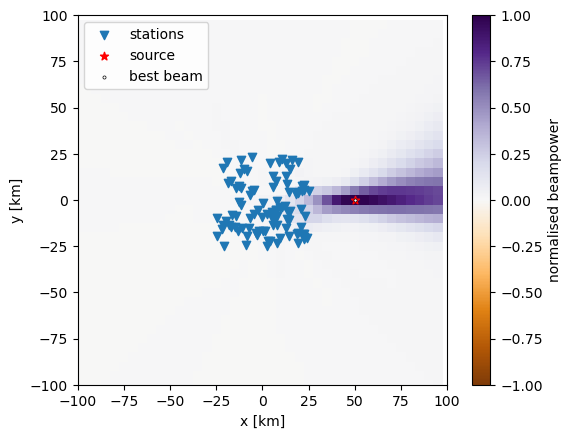

In [8]:
# plot beamforming result
fig, ax = plt.subplots(1)

bp = beampowers.reshape(len(grid_coords), len(grid_coords))
bp /= abs(bp).max()
pcm = ax.pcolormesh(xx, yy, bp.T, cmap="PuOr", vmin=-1, vmax=1)
ax.scatter(*stations.T, marker="v", label="stations")
ax.scatter(*source, marker="*", label="source", c="r")
ax.scatter(
    *gridpoints[bp.argmax()],
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=5,
    label="best beam",
)
# ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.1, alpha=0.5)
plt.colorbar(pcm, label="normalised beampower")
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect("equal")
ax.legend(loc=2)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
